
# Background

We are given a bank's loan records with information of individuals who have applied for loans. Some of the loans are approved and some are rejected. Out of the approved loans, some were repaid, and others were defaulted. The goal is to investigate if we could build a better model for the bank by examinig its loan data.

We take the approach of building a model that predicts whether an individual, if granted a loan, will repay the loan or not. With this model, we then predict how many of those who've been denied loans could have been good customers who repay their loans fully. The percentage of individuals who should've been granted loans could translate to an increase of financial returns for the bank for not denying good business.

# Import libraries

In [1]:
import zipfile
import os
import random
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import model_selection
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble # RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# User defined functions

In [96]:
def fill_na_KNN(df, column, model):
    """Treat missing values as a classification / regresion problem
    df = original dataframe with NA cols
    column = col you want to impute
    model = the classification or regression model used to fill in the NAs
    Returns imputed column.
    """
    ## Remove all cols containing NAs, except for the col we want to impute.
    # Split the cols with and without missing values
    colNAs = df.loc[:, df.isnull().any()]
    df = df.dropna(axis=1)
    # Join back the col we want to impute
    ndf = pd.concat([df, colNAs.loc[:, column]], axis=1)
    
    ## Split into rows with known (train) and missing values (test)
    # Get a row-wise boolean for the rows containing the NAs (in the specified col)
    nullmask = ndf[column].isnull()
    # The rows containing NAs are the testing data; otherwise the training data
    train, test  = ndf[~nullmask], ndf[nullmask]
    train_x, train_y = train.drop(column, axis=1), train[column]
    test_x, test_y = test.drop(column, axis=1), test[column]
    
    ## Fit KNN model
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    
    ## Stitch together the NA-filled dataset.
    # Arrange the rows in the original order to prepare for next imputation.
    # Converted the predicted array (np array) into a Series object with the orignal index
    pred_y = pd.Series(pred_y, index = test_y.index)
    new_y = new_y = pd.concat([train_y, pred_y]).sort_index()

    return new_y


def performCV(X_train, Y_train, cv, model):
    Y_pred = []
    Y_true = []
    for trainIdx, cvIdx in cv.split(X_train):
        Y_pred.append(model.fit(X_train.iloc[trainIdx],
                                Y_train.iloc[trainIdx]).predict_proba(X_train.iloc[cvIdx]))
        Y_true.append(Y_train.iloc[cvIdx])
    return Y_pred, Y_true
        
def unpackCVResults(Y_pred, Y_true):
    Y_pred_unpack = []
    Y_true_unpack = []
    for yp, yt in zip(Y_pred, Y_true):
        Y_pred_unpack.append([pred_val.argmax() for pred_val in yp])
        Y_true_unpack.append(list(yt.values))
    return Y_pred_unpack, Y_true_unpack

def getCVScores(Y_pred_unpack, Y_true_unpack):
    cvScore_Acc = []
    cvScore_Sens = []
    cvScore_Spec = []
    cvScore_Prec = []
    for yp, yt in zip(Y_pred_unpack, Y_true_unpack):
        cm = metrics.confusion_matrix(y_true = yt, y_pred = yp, labels=None)
        accuracy, sensitivity, specificity, precision = evalModel(cm)
        ## Alternative way of calculating accuracy instead of through cm:
        # match = [i for i, j in zip(Y_pred0, Y_true0) if i == j]
        # len(match) / float(len(Y_pred0))
        cvScore_Acc.append(accuracy)
        cvScore_Sens.append(sensitivity)
        cvScore_Spec.append(specificity)
        cvScore_Prec.append(precision)
    cvScore = pd.DataFrame({
            'accuracy': cvScore_Acc,
            'sensitivity': cvScore_Sens,
            'specificity': cvScore_Spec,
            'precision': cvScore_Prec,
            'recall': cvScore_Sens
        })
    return cvScore

def evalModel(cm):
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    P = FN + TP
    N = TN + FP
    Acc = (TN + TP) / float(P + N)
    sensitivity = TP / float(P)
    specificity = TN / float(N)
    precision = TP / float(TP+FP)
    NPV = TN / float(TN+FN)
    FPR = FP / float(FP+TN)
    FDR = FP / float(FP+TP)
    F1 = 2*TP / float(2*TP + FP + FN)
    return Acc, sensitivity, specificity, precision



# Load data

In [2]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 'borrower_table.csv',
 'Loan_granting.ipynb',
 'Loan_granting.zip',
 'loan_table.csv']

In [3]:
borrower = pd.read_csv('borrower_table.csv')
loan = pd.read_csv('loan_table.csv')

In [4]:
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [5]:
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


# Clean data

## 1. Merge data

Overall goal here is to predict if a loan should be granted to an individual or not. We therefore use the individuals who've been granted loans (loan_granted = 1) to train our model. We then use the denied rows (loan_granted = 0) as the test set, to see how many of these denied folks are actually predicted to honestly return their loans. This will be the money the bank lost.

In [6]:
print borrower.columns
print borrower.shape
print loan.columns
print loan.shape

Index([u'loan_id', u'is_first_loan', u'fully_repaid_previous_loans',
       u'currently_repaying_other_loans', u'total_credit_card_limit',
       u'avg_percentage_credit_card_limit_used_last_year', u'saving_amount',
       u'checking_amount', u'is_employed', u'yearly_salary', u'age',
       u'dependent_number'],
      dtype='object')
(101100, 12)
Index([u'loan_id', u'loan_purpose', u'date', u'loan_granted', u'loan_repaid'], dtype='object')
(101100, 5)


In [7]:
loanData = pd.merge(borrower, loan, how='inner', on='loan_id')

In [8]:
print loanData.columns
print loanData.shape

Index([u'loan_id', u'is_first_loan', u'fully_repaid_previous_loans',
       u'currently_repaying_other_loans', u'total_credit_card_limit',
       u'avg_percentage_credit_card_limit_used_last_year', u'saving_amount',
       u'checking_amount', u'is_employed', u'yearly_salary', u'age',
       u'dependent_number', u'loan_purpose', u'date', u'loan_granted',
       u'loan_repaid'],
      dtype='object')
(101100, 16)


In [9]:
granted = loanData[loanData.loan_granted == 1]
granted.drop('loan_granted', axis=1, inplace=True)
print granted.shape

(47654, 15)


/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
granted.describe()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid
count,47654.000000,47654.000000,21865.000000,21865.000000,47654.000000,46751.000000,47654.000000,47654.000000,47654.000000,47654.000000,47654.000000,47654.000000,47654.000000
mean,500187.775402,0.541172,0.902493,0.297736,4527.848659,0.700091,2022.366580,3499.160595,0.909829,29245.991942,41.524657,3.752445,0.644353
std,288925.682009,0.498307,0.296654,0.457273,1975.127016,0.177729,1493.410303,2155.128304,0.286429,16286.512395,12.817587,2.621351,0.478714
min,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000
25%,248669.250000,0.000000,1.000000,0.000000,3100.000000,0.580000,914.000000,1873.000000,1.000000,18900.000000,32.000000,2.000000,0.000000
50%,500013.500000,1.000000,1.000000,0.000000,4400.000000,0.710000,1553.000000,3024.500000,1.000000,29400.000000,41.000000,3.000000,1.000000
75%,750413.250000,1.000000,1.000000,1.000000,5800.000000,0.830000,2878.000000,4842.000000,1.000000,40200.000000,50.000000,6.000000,1.000000
max,999968.000000,1.000000,1.000000,1.000000,13500.000000,1.090000,10641.000000,13165.000000,1.000000,97200.000000,79.000000,8.000000,1.000000


## 2. Drop 'date' column

We can drop the date feature first to see if a good enough model can be built. If date features can offer further insight, e.g. default is more likely when the grant is applied in certain months, the column can be considered in future.

In [11]:
granted.drop('date', axis=1, inplace=True)

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## 3. Convert categorical variable into numeric

In [12]:
granted.dtypes

loan_id                                              int64
is_first_loan                                        int64
fully_repaid_previous_loans                        float64
currently_repaying_other_loans                     float64
total_credit_card_limit                              int64
avg_percentage_credit_card_limit_used_last_year    float64
saving_amount                                        int64
checking_amount                                      int64
is_employed                                          int64
yearly_salary                                        int64
age                                                  int64
dependent_number                                     int64
loan_purpose                                        object
loan_repaid                                        float64
dtype: object

In [13]:
granted.select_dtypes(include=['O']).columns

Index([u'loan_purpose'], dtype='object')

In [14]:
granted.loan_purpose.unique()

array(['other', 'business', 'emergency_funds', 'investment', 'home'], dtype=object)

There are five types of loan purposes. If one uses LabelEncoder, which generates ordinal labels -

In [15]:
purpose_encoder = LabelEncoder()
purpose_encoder.fit(granted.loan_purpose)
print purpose_encoder.transform(granted.loan_purpose)[:20]
print granted.loan_purpose[:20]

[4 4 0 1 0 0 0 1 0 3 2 0 2 0 1 0 3 0 1 2]
2               other
5               other
7            business
8     emergency_funds
9            business
10           business
11           business
13    emergency_funds
16           business
17         investment
21               home
22           business
23               home
31           business
35    emergency_funds
39           business
40         investment
42           business
45    emergency_funds
47               home
Name: loan_purpose, dtype: object


Since loan purposes don't have an ordinal relationship, one-hot encoding is more desirable. It retains more info by creating only four more columns.

In [16]:
for purpose in granted.loan_purpose.unique():
    granted['purpose_'+purpose] = granted.loan_purpose.str.contains(purpose).astype(int)
granted.drop('loan_purpose',axis=1, inplace=True)

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
granted.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid,purpose_other,purpose_business,purpose_emergency_funds,purpose_investment,purpose_home
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8,1.0,1,0,0,0,0
5,423171,1,NaN,NaN,6100,0.53,6163,5298,1,29500,24,1,1.0,1,0,0,0,0
7,200139,1,NaN,NaN,4000,0.57,602,2757,1,31700,36,8,0.0,0,1,0,0,0
8,991294,0,1.0,0.0,7000,0.52,2575,2917,1,58900,33,3,1.0,0,0,1,0,0
9,875332,0,1.0,0.0,4300,0.83,722,892,1,5400,32,7,1.0,0,1,0,0,0


## 4. Deal with missing values

Three columns have a large number of missing values. The strategy is to build models without these columns, or after imputing the missing values by k-nearest neighbor regression. Then compare the model performance.

In [18]:
loanData.isnull().sum()

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                        53446
dtype: int64

In [19]:
granted.isnull().sum()

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                        25789
currently_repaying_other_loans                     25789
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year      903
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
loan_repaid                                            0
purpose_other                                          0
purpose_business                                       0
purpose_emergency_funds                                0
purpose_investment                                     0
purpose_home                   

In [20]:
print 'Percentage of loans granted:', granted.shape[0]/float(loanData.shape[0])
print 'Percentage of individuals with payment history missing granted loans:', granted.isnull().sum()[2]/float(loanData.isnull().sum()[2])
print 'Percentage of individuals with credit-limit-use missing granted loans:', granted.isnull().sum()[5]/float(loanData.isnull().sum()[5])

Percentage of loans granted: 0.471355093966
Percentage of individuals with payment history missing granted loans: 0.469343185251
Percentage of individuals with credit-limit-use missing granted loans: 0.129518072289


It seems that the bank doesn't discriminate against people who've missing payment history when granting loans. But they do grant loans more to people whose credit limit use information is declared / known.

In [21]:
for key, group in granted.groupby('loan_repaid'):
    print 'Repaid loan?', key
    print 'Number of cases:', group.shape
    print '% of individuals with previous payment history missing:', group.fully_repaid_previous_loans.isnull().sum()/float(group.shape[0])
    print '% of individuals with current payment history missing:', group.currently_repaying_other_loans.isnull().sum()/float(group.shape[0])
    print '% of individuals with credit-limit-use missing:', group.avg_percentage_credit_card_limit_used_last_year.isnull().sum()/float(group.shape[0])

Repaid loan? 0.0
Number of cases: (16948, 18)
% of individuals with previous payment history missing: 0.532570214775
% of individuals with current payment history missing: 0.532570214775
% of individuals with credit-limit-use missing: 0.0440759971678
Repaid loan? 1.0
Number of cases: (30706, 18)
% of individuals with previous payment history missing: 0.545919364294
% of individuals with current payment history missing: 0.545919364294
% of individuals with credit-limit-use missing: 0.00508044030483


In [22]:
granted.corr()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid,purpose_other,purpose_business,purpose_emergency_funds,purpose_investment,purpose_home
loan_id,1.000000,0.002246,0.001710,0.005651,-0.000655,0.001768,-0.004482,-0.000531,0.012130,0.006602,0.011177,-0.000816,-0.002704,-0.003571,0.006619,-0.006748,0.003740,-0.001342
is_first_loan,0.002246,1.000000,NaN,NaN,0.003657,-0.004016,0.009611,0.010356,-0.000380,-0.002121,0.002591,-0.005861,0.012824,-0.001679,0.006942,-0.013316,0.002527,0.003613
fully_repaid_previous_loans,0.001710,NaN,1.000000,-0.015923,0.031333,-0.001759,0.014028,0.020963,0.002697,0.008098,0.009527,0.001105,0.038665,-0.014614,-0.006204,-0.002374,0.021886,-0.001077
currently_repaying_other_loans,0.005651,NaN,-0.015923,1.000000,-0.198214,0.094812,-0.251634,-0.248012,-0.154352,-0.215739,-0.008255,0.075054,-0.496350,0.023734,-0.043297,0.074131,-0.039280,-0.004114
total_credit_card_limit,-0.000655,0.003657,0.031333,-0.198214,1.000000,-0.076596,0.194137,0.203409,0.156715,0.186868,0.000168,-0.059254,0.401911,-0.029167,0.043437,-0.057069,0.032787,-0.001100
avg_percentage_credit_card_limit_used_last_year,0.001768,-0.004016,-0.001759,0.094812,-0.076596,1.000000,-0.098045,-0.101262,-0.089726,-0.102187,0.003110,0.026807,-0.209870,0.022634,-0.022539,0.030959,-0.007637,-0.015720
saving_amount,-0.004482,0.009611,0.014028,-0.251634,0.194137,-0.098045,1.000000,0.238092,0.148637,0.210556,-0.004327,-0.064931,0.493699,-0.037777,0.041576,-0.073808,0.042976,0.012296
checking_amount,-0.000531,0.010356,0.020963,-0.248012,0.203409,-0.101262,0.238092,1.000000,0.151237,0.210244,0.005039,-0.071816,0.494341,-0.036413,0.040610,-0.070055,0.039581,0.012180
is_employed,0.012130,-0.000380,0.002697,-0.154352,0.156715,-0.089726,0.148637,0.151237,1.000000,0.565322,0.005004,-0.042867,0.305749,-0.040120,0.025119,-0.040674,0.034891,0.009598
yearly_salary,0.006602,-0.002121,0.008098,-0.215739,0.186868,-0.102187,0.210556,0.210244,0.565322,1.000000,0.009329,-0.063628,0.426648,-0.038530,0.039910,-0.058598,0.037036,0.007215


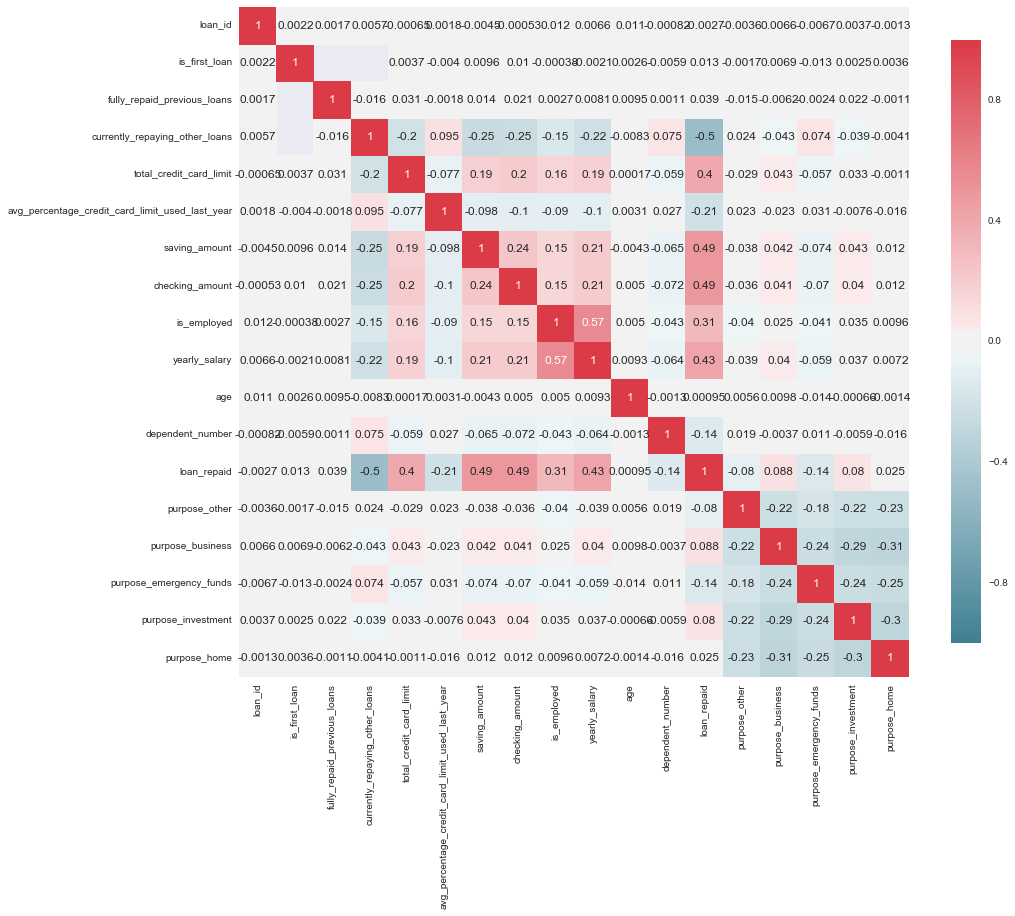

In [23]:
_, ax = plt.subplots(figsize = (15,12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(granted.corr(),
               cmap = cmap,
               square = True,
               cbar_kws = {'shrink': .9},
               ax = ax,
               annot = True,
               annot_kws = {'fontsize': 12})

The correlation plot illustrates several things relevant to missing values:

It appears that knowing loan payment history does not play a role in an individual's ability to repay loans. However, more than 75% of the individuals actually repaid their previous loans. Therefore it's a skewed dataset and mean imputation may not be accurate. Mode imputation (mode = 1.0) is more reasonable, but still dangerous to use. Considering the huge number of NAs, making them all 1.0 will skew the distribution heavily.

In [28]:
print granted.fully_repaid_previous_loans.unique()
print len(granted.fully_repaid_previous_loans)
print sum(granted.fully_repaid_previous_loans == 1)

[ nan   1.   0.]
47654
19733


The other two NA cols, disclosure of loan payment current status and credit limit, are more (positively) correlated with loan repayment. Altering the NA values may have a high influence on data. Considering these factors, we decide to fill in the missing values for three cols through regression.


### A. Ignore missing values

In [29]:
granted_noNA = granted.dropna(axis=1)

# or:
# granted_noNA = granted.drop(['fully_repaid_previous_loans',
#                              'currently_repaying_other_loans',
#                              'avg_percentage_credit_card_limit_used_last_year'], axis = 1)

print granted_noNA.shape
print granted_noNA.isnull().sum()

(47654, 15)
loan_id                    0
is_first_loan              0
total_credit_card_limit    0
saving_amount              0
checking_amount            0
is_employed                0
yearly_salary              0
age                        0
dependent_number           0
loan_repaid                0
purpose_other              0
purpose_business           0
purpose_emergency_funds    0
purpose_investment         0
purpose_home               0
dtype: int64


In [31]:
granted_noNA.dtypes

loan_id                      int64
is_first_loan                int64
total_credit_card_limit      int64
saving_amount                int64
checking_amount              int64
is_employed                  int64
yearly_salary                int64
age                          int64
dependent_number             int64
loan_repaid                float64
purpose_other                int64
purpose_business             int64
purpose_emergency_funds      int64
purpose_investment           int64
purpose_home                 int64
dtype: object

### B. Impute missing values

"Predict" missing values with k-nearest-neighbor regression or classification. Before doing this, it's crucial to scale the data because an uneven data space will mess up the KNN algorithm.

The following columns are on a different order of magnitude than the rest:

'total_credit_card_limit', 'saving_amount', 'checking_amount', 'yearly_salary', 'age', 'dependent_number'

These are all positive values with an actual siginificance in their positivity. Therefore a standard scaler ((x-mean)/std) is less appropriate than a min-max scaler ((x-min)/(max-min)).

In [73]:
granted_impNA = granted.copy()
# granted_impNA['fully_repaid_previous_loans'].fillna(granted_impNA['fully_repaid_previous_loans'].mean(), inplace=True)

In [74]:
r, c = KNeighborsRegressor(), KNeighborsClassifier(n_neighbors=5)
cols_to_impute = [('fully_repaid_previous_loans', c),
                  ('currently_repaying_other_loans', c),
                  ('avg_percentage_credit_card_limit_used_last_year', r)]
cols_to_scale = ['total_credit_card_limit',
                 'saving_amount',
                 'checking_amount',
                 'yearly_salary',
                 'age',
                 'dependent_number']

In [75]:
granted_impNA[cols_to_scale] = MinMaxScaler().fit_transform(granted_impNA[cols_to_scale])

In [76]:
granted_impNA.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid,purpose_other,purpose_business,purpose_emergency_funds,purpose_investment,purpose_home
2,135565,1,NaN,NaN,0.511111,0.82,0.195940,0.259932,1,0.252058,0.327869,1.000,1.0,1,0,0,0,0
5,423171,1,NaN,NaN,0.451852,0.53,0.579175,0.402431,1,0.303498,0.098361,0.125,1.0,1,0,0,0,0
7,200139,1,NaN,NaN,0.296296,0.57,0.056574,0.209419,1,0.326132,0.295082,1.000,0.0,0,1,0,0,0
8,991294,0,1.0,0.0,0.518519,0.52,0.241989,0.221572,1,0.605967,0.245902,0.375,1.0,0,0,1,0,0
9,875332,0,1.0,0.0,0.318519,0.83,0.067851,0.067755,1,0.055556,0.229508,0.875,1.0,0,1,0,0,0


In [77]:
for col, model in cols_to_impute:
    colImputed = fill_na_KNN(granted_impNA, col, model)
    granted_impNA[col] = colImputed
    print granted_impNA.isnull().sum()

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                            0
currently_repaying_other_loans                     25789
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year      903
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
loan_repaid                                            0
purpose_other                                          0
purpose_business                                       0
purpose_emergency_funds                                0
purpose_investment                                     0
purpose_home                   

In [78]:
print granted_impNA.shape
granted_impNA.head()

(47654, 18)


,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid,purpose_other,purpose_business,purpose_emergency_funds,purpose_investment,purpose_home
2,135565,1,1.0,0.0,0.511111,0.82,0.195940,0.259932,1,0.252058,0.327869,1.000,1.0,1,0,0,0,0
5,423171,1,1.0,0.0,0.451852,0.53,0.579175,0.402431,1,0.303498,0.098361,0.125,1.0,1,0,0,0,0
7,200139,1,1.0,0.0,0.296296,0.57,0.056574,0.209419,1,0.326132,0.295082,1.000,0.0,0,1,0,0,0
8,991294,0,1.0,0.0,0.518519,0.52,0.241989,0.221572,1,0.605967,0.245902,0.375,1.0,0,0,1,0,0
9,875332,0,1.0,0.0,0.318519,0.83,0.067851,0.067755,1,0.055556,0.229508,0.875,1.0,0,1,0,0,0


## 5. Drop 'loan_id' column

In [79]:
granted_noNA.drop('loan_id', axis=1, inplace = True)
granted_impNA.drop('loan_id', axis=1, inplace = True)

In [80]:
print granted_noNA.shape
print granted_impNA.shape

(47654, 14)
(47654, 17)


## 6. Scaling continued...

Lastly, bring back the non-scaled version of both 'noNA' and 'impNA' datasets.


In [81]:
granted_noNA_sca = granted_noNA.copy()
granted_noNA_sca[cols_to_scale] = MinMaxScaler().fit_transform(granted_noNA_sca[cols_to_scale])

In [82]:
granted_impNA_sca = granted_impNA.copy()
granted_impNA[cols_to_scale] = granted_noNA[cols_to_scale]

In [83]:
print granted_noNA.shape
print granted_impNA.shape

print granted_noNA_sca.shape
print granted_impNA_sca.shape

(47654, 14)
(47654, 17)
(47654, 14)
(47654, 17)


# Build models to predict grant repayment

In [87]:
dfs = [granted_noNA, granted_impNA, granted_noNA_sca, granted_impNA_sca]

## Dataset 1: Ignored NAs, not scaled

### 1. Make training and testing data

In [106]:
Y = dfs[0].loan_repaid
X = dfs[0].drop('loan_repaid', axis = 1)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(33357, 13)
(14297, 13)
(33357,)
(14297,)


### 2. Set up model and cross-validation

Note a bias-variance tradeoff in choosing k -
- Small k: Low variance in predicted results, but high bias in models. (e.g. split into half; validate twice; one model may not be too different from the other, but they may not generalize well because they haven't seen too much data)
- Large k: High variance in predicted results, but low bias in models. (e.g. leave-one-out; validate n times; the final model capture the characteristics of a lot of models, but may be overfitted - n times! - to existing data)

In [131]:
key_value_pairs = [('naive Bayes', GaussianNB()),
                   ('logistic regression', linear_model.LogisticRegression()),
                   ('SVM', svm.SVC(degree=0.5)),
                   ('random forest', ensemble.RandomForestClassifier(n_estimators=100))
                  ]
models = collections.OrderedDict(key_value_pairs)

cv10 = model_selection.KFold(n_splits=10)

### 3. Perform cross-validation

In [107]:
model = models.get('random forest')
Y_pred, Y_true = performCV(X_train, Y_train, cv=cv10, model = model)
Y_pred_unpack, Y_true_unpack = unpackCVResults(Y_pred, Y_true)
cvScore = getCVScores(Y_pred_unpack, Y_true_unpack)

cvScore

,accuracy,precision,recall,sensitivity,specificity
0,0.905276,0.942391,0.909217,0.909217,0.898046
1,0.909173,0.937739,0.918817,0.918817,0.892116
2,0.907974,0.941948,0.916629,0.916629,0.891323
3,0.910671,0.932921,0.925873,0.925873,0.884236
4,0.921163,0.946190,0.929808,0.929808,0.905755
5,0.911571,0.949707,0.910154,0.910154,0.914095
6,0.912470,0.947814,0.917615,0.917615,0.902546
7,0.914843,0.943765,0.919485,0.919485,0.906958
8,0.909445,0.933715,0.923149,0.923149,0.885502
9,0.914243,0.948850,0.919509,0.919509,0.904049


Simply throwing away the NA cols, predicts us the probability of users repaying / defaulting on their loans pretty darn well. (Note that RFs are rather tolerant to no scaling.)

### 4. Apply on unseen (test) data

In [98]:
Y_test_pred = model.fit(X_train, Y_train).predict_proba(X_test)
Y_test_pred_unpack = [pred_val.argmax() for pred_val in Y_test_pred]

cm_test = metrics.confusion_matrix(y_true = Y_test, y_pred = Y_test_pred_unpack, labels=None)
accuracy, sensitivity, specificity, precision = evalModel(cm_test)
print 'Model: ', model
print 'Testing accuracy: ', accuracy
print 'Testing precision: ', precision
print 'Testing recall: ', sensitivity

Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Testing accuracy:  0.915506749668
Testing precision:  0.94496942746
Testing recall:  0.922609356344


### 5. Insights from model

In [99]:
Y_test_pred_featImp = model.fit(X_train, Y_train)

importances = model.feature_importances_
std = np.std([indivTree.feature_importances_ for indivTree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. saving_amount (0.321948)
2. checking_amount (0.275183)
3. yearly_salary (0.149150)
4. total_credit_card_limit (0.120505)
5. age (0.044307)
6. is_employed (0.027806)
7. dependent_number (0.027349)
8. purpose_emergency_funds (0.008484)
9. is_first_loan (0.007772)
10. purpose_business (0.004682)
11. purpose_investment (0.004497)
12. purpose_other (0.004294)
13. purpose_home (0.004023)


Several things checked out against the simple correlation run earlier:
- Cash positions such as back account, salary matter highly
- Loan purpose for emergency matters more than the other purposes

Age, interestingly, matters moderately highly.

Now plot the feature importances of the forest.

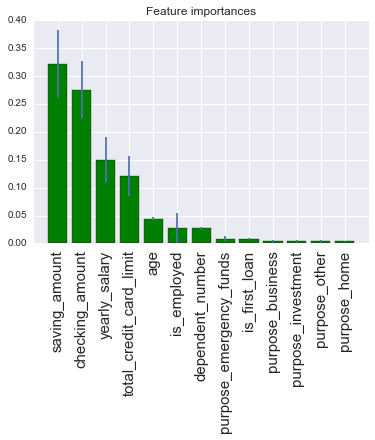

In [100]:
fig, ax = plt.subplots()
# plt.figure() # If this line is included, an empty plot appears.
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation=90)
plt.xlim([-1, X_train.shape[1]])
ax.set_xticklabels(X_train.columns[indices], rotation=90, size=15)
plt.show() # If this line is not included, a bunch of msgs appear

While one can try a different model or do grid-search to tune the RF parameters, priority of this action is low since default params performed pretty well in this case. It would be more interesting to compare with a model built from the dataset with features containing guessed NA values.

## Dataset 2: Imputed NAs, not scaled

### 1. Make training and testing data

In [108]:
Y = dfs[1].loan_repaid
X = dfs[1].drop('loan_repaid', axis = 1)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(33357, 16)
(14297, 16)
(33357,)
(14297,)


### 2. Set up model and cross-validation

In [95]:
key_value_pairs = [('naive Bayes', GaussianNB()),
                   ('logistic regression', linear_model.LogisticRegression()),
                   ('SVM', svm.SVC(degree=0.5)),
                   ('decision tree', tree.DecisionTreeClassifier()),
                   ('random forest', ensemble.RandomForestClassifier(n_estimators=100))
                  ]
models = collections.OrderedDict(key_value_pairs)

cv10 = model_selection.KFold(n_splits=10)

### 3. Perform cross-validation

In [103]:
model = models.get('random forest')
Y_pred, Y_true = performCV(X_train, Y_train, cv=cv10, model = model)
Y_pred_unpack, Y_true_unpack = unpackCVResults(Y_pred, Y_true)
cvScore = getCVScores(Y_pred_unpack, Y_true_unpack)

cvScore

,accuracy,precision,recall,sensitivity,specificity
0,0.915168,0.944972,0.922649,0.922649,0.901444
1,0.914269,0.943296,0.921164,0.921164,0.902075
2,0.913369,0.944496,0.922551,0.922551,0.895706
3,0.921163,0.940199,0.935316,0.935316,0.896552
4,0.925959,0.947867,0.935891,0.935891,0.908257
5,0.917566,0.952821,0.916706,0.916706,0.919099
6,0.920264,0.950537,0.927173,0.927173,0.906936
7,0.922339,0.947907,0.927585,0.927585,0.913430
8,0.914843,0.934690,0.931165,0.931165,0.886326
9,0.918141,0.948324,0.926330,0.926330,0.902289


Is this better? Can't quite tell. Let's go onto testing.

### 4. Apply on unseen (test) data

In [104]:
Y_test_pred = model.fit(X_train, Y_train).predict_proba(X_test)
Y_test_pred_unpack = [pred_val.argmax() for pred_val in Y_test_pred]

cm_test = metrics.confusion_matrix(y_true = Y_test, y_pred = Y_test_pred_unpack, labels=None)
accuracy, sensitivity, specificity, precision = evalModel(cm_test)
print 'Model: ', model
print 'Testing accuracy: ', accuracy
print 'Testing precision: ', precision
print 'Testing recall: ', sensitivity

Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Testing accuracy:  0.922011610827
Testing precision:  0.947601149679
Testing recall:  0.930424400304


Slightly better testing performance, from **91.5%** to **92.2%** accuracy.

### 5. Insights from model

In [136]:
Y_test_pred_featImp = model.fit(X_train, Y_train)

importances = model.feature_importances_
std = np.std([indivTree.feature_importances_ for indivTree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. saving_amount (0.313070)
2. checking_amount (0.260543)
3. yearly_salary (0.127130)
4. total_credit_card_limit (0.103917)
5. avg_percentage_credit_card_limit_used_last_year (0.046815)
6. age (0.033202)
7. is_employed (0.030637)
8. currently_repaying_other_loans (0.023752)
9. dependent_number (0.022118)
10. is_first_loan (0.011961)
11. purpose_emergency_funds (0.006753)
12. purpose_business (0.004955)
13. purpose_investment (0.004498)
14. purpose_home (0.004279)
15. purpose_other (0.004154)
16. fully_repaid_previous_loans (0.002215)


The presence of several moderately high-ranking features improved the model accuracy, especially 'avg_percentage_credit_card_limit_used_last_year'.

Whether or not previous loans have been fully repaid matters the least. It explains why leaving it out previously didn't impact the accuracy all that much.

Now plot the feature importances of the forest.

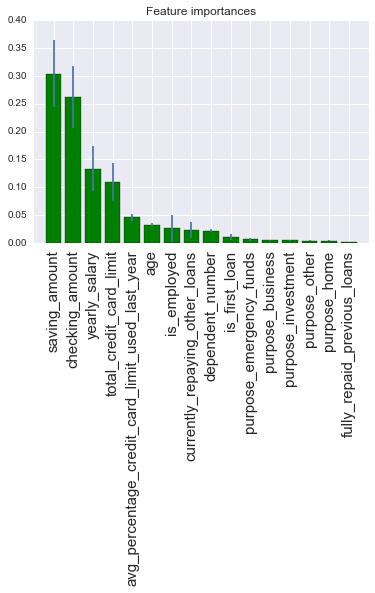

In [110]:
fig, ax = plt.subplots()
# plt.figure() # If this line is included, an empty plot appears.
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation=90)
plt.xlim([-1, X_train.shape[1]])
ax.set_xticklabels(X_train.columns[indices], rotation=90, size=15)
plt.show() # If this line is not included, a bunch of msgs appear

# Predict repayment in those denied the loan

Now, to see how many cases the bank missed out on.

First we need to take the "loans denied" data through the same cleaning. Then use the granted data with imputed missing values for prediction.

Here it would be interesting to note if a better model can be built by imputing missing values from the entire loanData, not just from the granted dataset. Let's take the imputation of the granted dataset as what we've done for now.

Just to remind ourselves, the granted data has 16 features:

In [111]:
granted_impNA.shape

(47654, 17)

## Clean data
### 1. Drop unhelpful columns

In [114]:
denied = loanData[loanData.loan_granted == 0]
denied.drop(['loan_id', 'loan_granted', 'date', 'loan_granted', 'loan_repaid'], axis=1, inplace=True)
print denied.shape

(53446, 12)


/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### 2. Convert categorical variable into numeric

In [115]:
for purpose in denied.loan_purpose.unique():
    denied['purpose_'+purpose] = denied.loan_purpose.str.contains(purpose).astype(int)
denied.drop('loan_purpose',axis=1, inplace=True)

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [116]:
denied.head()

,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,purpose_business,purpose_investment,purpose_emergency_funds,purpose_other,purpose_home
0,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3,1,0,0,0,0
1,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1,0,1,0,0,0
3,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1,0,1,0,0,0
4,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1,0,0,1,0,0
6,1,NaN,NaN,600,0.89,305,1456,0,0,50,2,0,0,1,0,0


### 3. Deal with missing values

In [117]:
denied_impNA = denied.copy()

In [118]:
r, c = KNeighborsRegressor(), KNeighborsClassifier(n_neighbors=5)
cols_to_impute = [('fully_repaid_previous_loans', c),
                  ('currently_repaying_other_loans', c),
                  ('avg_percentage_credit_card_limit_used_last_year', r)]
cols_to_scale = ['total_credit_card_limit',
                 'saving_amount',
                 'checking_amount',
                 'yearly_salary',
                 'age',
                 'dependent_number']

In [119]:
denied_impNA[cols_to_scale] = MinMaxScaler().fit_transform(denied_impNA[cols_to_scale])

In [121]:
denied_impNA.head()

,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,purpose_business,purpose_investment,purpose_emergency_funds,purpose_other,purpose_home
0,1,NaN,NaN,0.601504,0.49,0.340133,0.077095,0,0.000000,0.475410,0.375,1,0,0,0,0
1,0,1.0,0.0,0.338346,1.03,0.065852,0.381014,1,0.148842,0.245902,0.125,0,1,0,0,0
3,0,1.0,0.0,0.090226,0.82,0.037068,0.243581,0,0.000000,0.098361,0.125,0,1,0,0,0
4,0,0.0,0.0,0.518797,0.80,0.221371,0.307875,1,0.199559,0.295082,0.125,0,0,1,0,0
6,1,NaN,NaN,0.045113,0.89,0.031580,0.104639,0,0.000000,0.524590,0.250,0,0,1,0,0


In [122]:
for col, model in cols_to_impute:
    colImputed = fill_na_KNN(denied_impNA, col, model)
    denied_impNA[col] = colImputed
    print denied_impNA.isnull().sum()

is_first_loan                                          0
fully_repaid_previous_loans                            0
currently_repaying_other_loans                     29158
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6069
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
purpose_business                                       0
purpose_investment                                     0
purpose_emergency_funds                                0
purpose_other                                          0
purpose_home                                           0
dtype: int64
is_first_loan                                         0
fully_repaid_previo

In [123]:
denied_impNA_sca = denied_impNA.copy()
denied_impNA[cols_to_scale] = denied[cols_to_scale]

In [125]:
print denied_impNA.shape
denied_impNA.head()

(53446, 16)


,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,purpose_business,purpose_investment,purpose_emergency_funds,purpose_other,purpose_home
0,1,1.0,0.0,8000,0.49,3285,1073,0,0,47,3,1,0,0,0,0
1,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1,0,1,0,0,0
3,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1,0,1,0,0,0
4,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1,0,0,1,0,0
6,1,1.0,0.0,600,0.89,305,1456,0,0,50,2,0,0,1,0,0


## Use the RF model to predict how many cases would've repaid loans
### 1. Make training and testing data

In [126]:
Y_train = granted_impNA.loan_repaid
X_train = granted_impNA.drop('loan_repaid', axis = 1)

X_test = denied_impNA

print X_train.shape
print X_test.shape
print Y_train.shape

(47654, 16)
(53446, 16)
(47654,)


In [138]:
model = models.get('random forest')
Y_test_pred = model.fit(X_train, Y_train).predict_proba(X_test)
Y_test_pred_unpack = [pred_val.argmax() for pred_val in Y_test_pred]

# cm_test = metrics.confusion_matrix(y_true = Y_test, y_pred = Y_test_pred_unpack, labels=None)
# accuracy, sensitivity, specificity, precision = evalModel(cm_test)
print 'Model: ', model
print 'Number of cases denied loan:', X_test.shape[0]
print 'Number of cases predicted to repay loan had they been granted one: ', sum(Y_test_pred_unpack)
print 'Percentage of potential revenue lost:', sum(Y_test_pred_unpack)/float(X_test.shape[0])

Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Number of cases denied loan: 53446
Number of cases predicted to repay loan had they been granted one:  18443
Percentage of potential revenue lost: 0.345077274258


The bank missed 35% of the business it could've done by granting a loan, which in turn could've yielded a return.


# Summary and conclusion

By analyzing the loan applications where loan has been granted, we built a model that predicts an individual's ability to repay a loan at 92% accuracy. We find that the following attributes of a person helps with prediction:
1. His/Her cash position (bank accounts, salary)
2. His/Her credit position (total credit card limit, previous limit use)
3. His/her age, employment status, other loan commitment and number of dependents
4. He/She is less likely to repay the loan if the purpose of borrowing had been for emergency needs

Applying the model on the cases that have been denied a loan, we find that up to 35% of these cases could have repaid the loan. Therefore our prediction would help the bank justify not to be too conservative on granting loans, which potentially causes non trivial losses.